# Семинар 11: Знакомство с набором данных MNIST. Построение модели KNeighborsClassifier

### Основы API

Чаще всего использование API Scikit-Learn Estimator происходит следующим образом:

1. Выбирается класс модели, импортировав соответствующий класс из Scikit-Learn.
2. Подбираем значения гиперпараметров модели, инстанцировав класс модели с нужными значениями параметров.
3. Разделение данные на матрицу признаков и целевой вектор.
4. Настройка модели посредством метода `fit` экземпляра модели.
5. Применение модели к новым данным:
   - Для `supervised learning` (обучение с учителем) мы предсказываем метки для неизвестных данных с помощью метода `predict`.
   - Для `unsupervised learning` (обучение без учителя) мы преобразуем или оцениваем свойства примеров из набора данных с помощью методов `transform` или `predict`.

Согласно вышеуказнной последовательность требуется выполнить следующее задание:

1. Загрузить набор данных [MNIST]( http://yann.lecun.com/exdb/mnist/ )
2. Исследовать его. Вывести разнообразные числовые характериcтики набора данных, а также визуализировать отдельные элементы данных.
3. Разработать программный код, который позволит построить модель KNeighborsClassifier
4. Вывести метрики Confusion Matrix, Precision, Recall
5. Описать полученные результаты

Бонус 
    На втором семинаре было дано введение в объектно-ориентированное программирование, попробуйте реализовать собственный класс модели. 
    Реализация должна поддерживать API Scikit-Learn, что позволит использовать возможности Scikit-Learn


In [1]:
import numpy   as np
import seaborn as sb
import pandas  as pd

import struct

from sklearn.metrics import confusion_matrix, accuracy_score

from array    import array
from os.path  import join
from tqdm     import tqdm

#
# MNIST Data Loader Class
#
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test) 

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import random
#
# Set file paths based on added MNIST Datasets
#
input_path = 'input'
training_images_filepath = join(input_path, 'train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte')
test_images_filepath     = join(input_path, 't10k-images-idx3-ubyte')
test_labels_filepath     = join(input_path, 't10k-labels-idx1-ubyte')

mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train_list, y_train_list), (x_test_list, y_test_list) = mnist_dataloader.load_data()

## Преобразуем данные в Numpy массивы

In [3]:
x_train_numpy = np.array(x_train_list)
y_train_numpy = np.array(y_train_list)
x_test_numpy  = np.array(x_test_list )
y_test_numpy  = np.array(y_test_list ) 

In [4]:
print(x_train_numpy.shape)
print(y_train_numpy.shape)
print(x_test_numpy .shape)
print(y_test_numpy .shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [5]:
#from scipy.ndimage import zoom
#x_train_numpy = np.array([ zoom(x, (0.25, 0.25)) for x in x_train_numpy ] )
#x_test_numpy  = np.array([ zoom(x, (0.25, 0.25)) for x in x_test_numpy  ] )

In [6]:
seq = np.random.randint(0,60000,6000)
x_train_numpy = x_train_numpy[seq]
y_train_numpy = y_train_numpy[seq]

print( x_train_numpy.shape )
print( y_train_numpy.shape )

(6000, 28, 28)
(6000,)


In [7]:
x_train_numpy = x_train_numpy.reshape(x_train_numpy.shape[0], -1)
y_train_numpy = y_train_numpy.reshape(-1)
x_test_numpy  = x_test_numpy .reshape(x_test_numpy .shape[0], -1)
y_test_numpy  = y_test_numpy .reshape(-1)

In [8]:
print(x_train_numpy.shape)
print(y_train_numpy.shape)
print(x_test_numpy .shape)
print(y_test_numpy .shape)

(6000, 784)
(6000,)
(10000, 784)
(10000,)


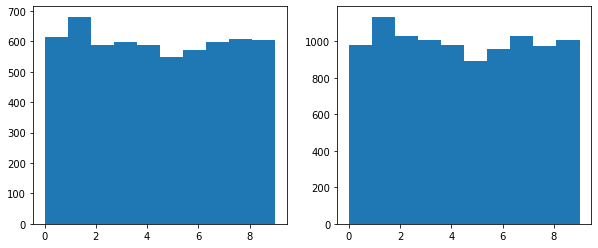

In [9]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].hist(y_train_numpy)
ax[1].hist(y_test_numpy)
plt.show()

## Модель sklearn.neighbors.KNeighborsClassifier

In [10]:
from sklearn.neighbors import KNeighborsClassifier

In [11]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

knn = KNeighborsClassifier(n_neighbors = 5)
scores = cross_val_score(knn, x_train_numpy, y_train_numpy, cv=5, scoring='accuracy') 
print(scores)
print(scores.mean())

[0.93916667 0.9275     0.94083333 0.93916667 0.92666667]
0.9346666666666668


In [12]:
from sklearn.model_selection import GridSearchCV

knn = KNeighborsClassifier()
param_grid = dict(n_neighbors = list(range(4, 6)), weights = ['uniform', 'distance' ] )

grid = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', return_train_score=False,verbose=1)
grid_search=grid.fit(x_train_numpy, y_train_numpy)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


In [13]:
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [14]:
y_pred_numpy = grid_search.best_estimator_.predict(x_test_numpy)

In [15]:
accuracy_score(y_test_numpy, y_pred_numpy)

0.9423

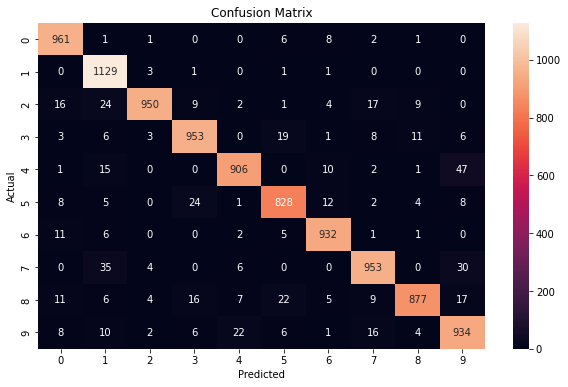

In [16]:
cm = confusion_matrix(y_test_numpy, y_pred_numpy)
plt.subplots(figsize=(10, 6))
sb.heatmap(cm, annot = True, fmt = 'g')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

### Можно ли процесс оптимизировать?

In [17]:
knn = KNeighborsClassifier()
knn.fit(x_train_numpy, y_train_numpy)

param_grid = dict(n_neighbors = list(range(3, 6)), weights = ['uniform', 'distance' ] )

for n_neighbors in param_grid['n_neighbors'] :
    for weights in param_grid['weights'] :
        knn.n_neighbors = n_neighbors
        knn.weights     = weights
        
        y_pred_numpy = knn.predict(x_test_numpy)
        
        print( f'n_neighbors={n_neighbors}, weights={weights}, {accuracy_score(y_test_numpy, y_pred_numpy)}' )

n_neighbors=3, weights=uniform, 0.9387
n_neighbors=3, weights=distance, 0.9409
n_neighbors=4, weights=uniform, 0.9368
n_neighbors=4, weights=distance, 0.9423
n_neighbors=5, weights=uniform, 0.9384
n_neighbors=5, weights=distance, 0.9411


In [18]:
knn.n_neighbors = 3
knn.weights     = 'distance'

y_pred_numpy = knn.predict(x_test_numpy)
accuracy_score(y_test_numpy, y_pred_numpy)

0.9409

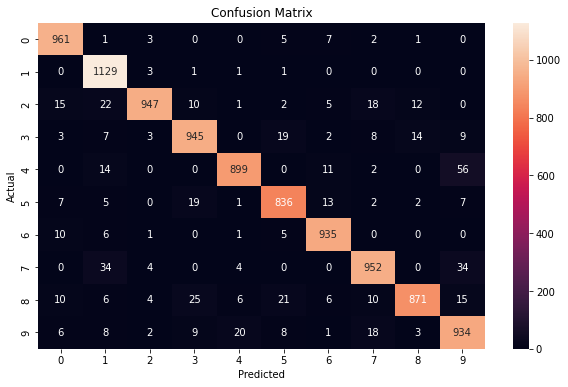

In [19]:
cm = confusion_matrix(y_test_numpy, y_pred_numpy)
plt.subplots(figsize=(10, 6))
sb.heatmap(cm, annot = True, fmt = 'g')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## Модель sklearn.svm.LinearSVC

In [20]:
from sklearn.svm import LinearSVC

svm = LinearSVC(dual=False)
svm.fit(x_train_numpy, y_train_numpy)

/home/sergey/anaconda3/envs/work/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(dual=False)

In [21]:
y_pred_numpy = svm.predict(x_test_numpy)

In [22]:
accuracy_score(y_test_numpy, y_pred_numpy)

0.8189

In [23]:
C_s = [0.0001,0.001,0.01,0.1,1,10,100,1000,10000]

result_df = pd.DataFrame(columns = ['C','train_accuracy', 'test_accuracy'])

for i, c in tqdm(enumerate(C_s)):
    svm = LinearSVC(dual=False, C=c)
    svm.fit(x_train_numpy, y_train_numpy)
        
    y_pred_numpy   = svm.predict(x_train_numpy)
    train_accuracy = accuracy_score(y_train_numpy, y_pred_numpy)
    y_pred_numpy   = svm.predict(x_test_numpy)
    test_accuracy  = accuracy_score(y_test_numpy , y_pred_numpy)
    
    result_df.loc[i] =[ c, train_accuracy, test_accuracy ]

2it [00:24, 13.66s/it]/home/sergey/anaconda3/envs/work/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
3it [01:11, 28.97s/it]/home/sergey/anaconda3/envs/work/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
4it [01:51, 33.23s/it]/home/sergey/anaconda3/envs/work/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
5it [02:26, 33.72s/it]/home/sergey/anaconda3/envs/work/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
6it [02:57, 32.87s/it]/home/sergey/anaconda3/envs/work/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to co

На графике хорошо виден компромисс между смещением и дисперсией. С увеличением `C` точность обучения растет, как и точность тестирования, но только до `C=1`, после чего мы видим перебор. Начиная с `C=10` и до `1000` мы видим, что модель перестраивается, и мы видим низкую погрешность и высокую дисперсию.
Таким образом, по мере продвижения слева направо: Bias уменьшается, а Variance увеличивается.

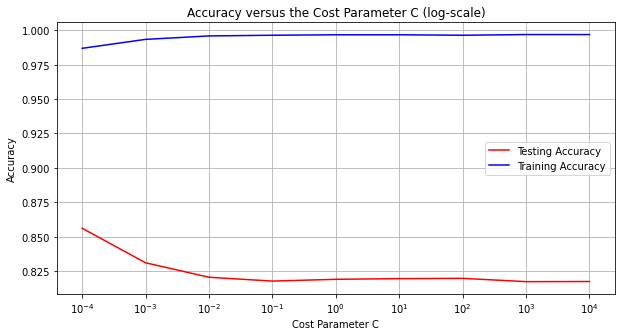

In [24]:
plt.subplots(figsize=(10, 5))
plt.semilogx(result_df['C'].values, result_df['test_accuracy' ].values, color='red' , label="Testing Accuracy")
plt.semilogx(result_df['C'].values, result_df['train_accuracy'].values, color='blue', label="Training Accuracy")
plt.grid(True)
plt.xlabel("Cost Parameter C")
plt.ylabel("Accuracy")
plt.legend()
plt.title('Accuracy versus the Cost Parameter C (log-scale)')
plt.xticks(C_s)
plt.show()

### Linear SVC + L1

In [25]:
C_s = [0.0001,0.001,0.01,0.1,1,10,100,1000,10000]

result_df = pd.DataFrame(columns = ['C','train_accuracy', 'test_accuracy'])

for i, c in tqdm(enumerate(C_s)):
    svm = LinearSVC(dual=False, C=c, penalty='l1' )
    svm.fit(x_train_numpy, y_train_numpy)
        
    y_pred_numpy   = svm.predict(x_train_numpy)
    train_accuracy = accuracy_score(y_train_numpy, y_pred_numpy)
    y_pred_numpy   = svm.predict(x_test_numpy)
    test_accuracy  = accuracy_score(y_test_numpy , y_pred_numpy)
    
    result_df.loc[i] =[ c, train_accuracy, test_accuracy ]

2it [00:39, 21.67s/it]/home/sergey/anaconda3/envs/work/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
3it [01:30, 35.03s/it]/home/sergey/anaconda3/envs/work/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
4it [02:19, 40.30s/it]/home/sergey/anaconda3/envs/work/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
5it [03:02, 41.42s/it]/home/sergey/anaconda3/envs/work/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
6it [04:18, 53.33s/it]/home/sergey/anaconda3/envs/work/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to co

На графике мы наблюдаем компромисс между смещением и дисперсией. С увеличением `С` точность обучения растет, как и точность тестирования, но только до `C=1`. Начиная с `C=10` и до `1000` мы видим, что модель переобучается, и мы видим низкую погрешность и высокую дисперсию. Единственное, при использовании L1 эффект переобучения меньше, и модель работает очень плохо при меньших значениях стоимости.
Опять же, по мере продвижения слева направо: смещение уменьшается, а вариация увеличивается


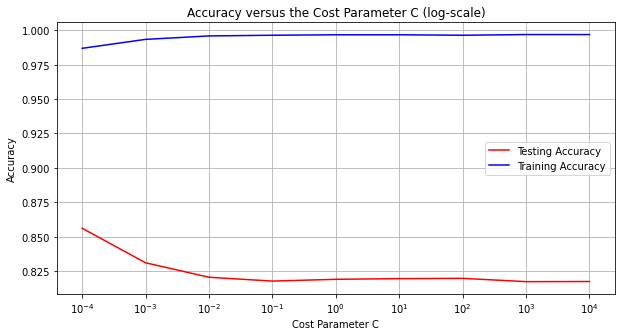

In [26]:
plt.subplots(figsize=(10, 5))
plt.semilogx(result_df['C'].values, result_df['test_accuracy' ].values, color='red' , label="Testing Accuracy")
plt.semilogx(result_df['C'].values, result_df['train_accuracy'].values, color='blue', label="Training Accuracy")
plt.grid(True)
plt.xlabel("Cost Parameter C")
plt.ylabel("Accuracy")
plt.legend()
plt.title('Accuracy versus the Cost Parameter C (log-scale)')
plt.xticks(C_s)
plt.show()

In [27]:
from sklearn.svm import SVC

### SVC RBF ядра

In [ ]:
C_s = [0.01, 0.1, 1, 10, 100]
gamma_s = [0.01, 0.1, 1, 10, 100]

result_df = pd.DataFrame(columns = ['c','gamma','train_accuracy','test_accuracy'])

for i, c in tqdm(enumerate(C_s)):
    for j, g in enumerate(gamma_s):
        svm   = SVC(kernel='rbf', C=c, gamma=g)
        model = svm.fit(x_train_numpy, y_train_numpy)
        
        y_pred_numpy   = svm.predict(x_train_numpy)
        train_accuracy = accuracy_score(y_train_numpy, y_pred_numpy)
        y_pred_numpy   = svm.predict(x_test_numpy)
        test_accuracy  = accuracy_score(y_test_numpy , y_pred_numpy)
        
        result_df.loc[i*len(gamma_s) + j] =[ c, g, train_accuracy, test_accuracy ]

2it [35:40, 1054.12s/it]

In [ ]:
result_df

Прокомментируйте смещение и дисперсию классификатора SVC относительно C и гаммы. Прокомментируйте результаты в целом по сравнению с LinearSVC. Какие значения вы бы выбрали?

В таблице мы видим компромисс между смещением и дисперсией. При увеличении стоимости и гаммы точность тестирования снижается, так как наблюдается переподгонка. Мы видим, что модель перестраивается и имеет низкую погрешность и высокую дисперсию. Интересно, что при неизменной стоимости и увеличении гаммы мы сразу же получаем избыточную подгонку. При этом стоимость ведет себя так же, как и в линейном SVC, с той лишь разницей, что наилучшая производительность модели здесь - C=10 и Gamma=0.01.
Таким образом, при увеличении Cost: Bias уменьшается, а Variance увеличивается. Таким образом, при увеличении гаммы: Bias уменьшается, а Variance увеличивается.

### SVC Poly ядро

In [ ]:
C_s = [0.01, 0.1, 1, 10, 100]
degree_s = [2,3,4]

result_df = pd.DataFrame(columns = ['c','degree','train_accuracy','test_accuracy'])

for i, c in tqdm(enumerate(C_s)):
    for j, d in enumerate(degree_s):
        svm   = SVC(kernel='poly', C=c, degree=d)
        model = svm.fit(x_train_numpy, y_train_numpy)
        
        y_pred_numpy   = svm.predict(x_train_numpy)
        train_accuracy = accuracy_score(y_train_numpy, y_pred_numpy)
        y_pred_numpy   = svm.predict(x_test_numpy)
        test_accuracy  = accuracy_score(y_test_numpy , y_pred_numpy)
        
        result_df.loc[i*len(degree_s) + j] =[ c, d, train_accuracy, test_accuracy ]

In [ ]:
result_df

Прокомментируйте смещение и дисперсию классификатора SVC относительно C и степени. Прокомментируйте результаты в целом по сравнению с LinearSVC. Какие значения вы бы выбрали?

Мы также видим, что полиномиальное ядро ведет себя очень странно, поскольку изменение стоимости и степени влияет на всю гиперплоскость полинома, а не на локализованную гиперплоскость, как в случае ядра rbf, следовательно, полиномиальное ядро менее устойчиво, чем rbf.

В таблице мы видим компромисс между смещением и дисперсией. При увеличении стоимости и степени точность тестирования снижается, наблюдается переобучение. Мы видим, что модель перестраивается и имеет низкую погрешность и высокую дисперсию. Интересно, что при неизменной стоимости, увеличивая степень, мы сразу же получаем избыточную подгонку. При этом стоимость ведет себя так же, как и в линейном SVC, с той лишь разницей, что наилучшая производительность модели здесь - C=100 и степень=2.
Таким образом, при увеличении Cost: Bias уменьшается, а Variance увеличивается.
При увеличении степени: Bias уменьшается, а Variance увеличивается.

### SVC RootPoly ядро

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

RP_REGRESSION_TERMS_P1 = np.array([
    [1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0], [0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 1]
])
RP_REGRESSION_TERMS_P2 = np.concatenate((RP_REGRESSION_TERMS_P1,
np.array([
    [1/2, 1/2,   0,   0,   0,   0], [1/2,   0, 1/2,   0,   0,   0], [1/2,   0, 0, 1/2,   0,   0], [1/2, 0  , 0, 0, 1/2, 0], [1/2, 0, 0, 0, 0, 1/2],
    [  0, 1/2, 1/2,   0,   0,   0], [  0, 1/2,   0, 1/2,   0,   0], [0  , 1/2, 0,   0, 1/2,   0], [0  , 1/2, 0, 0, 0, 1/2],
    [  0,   0, 1/2, 1/2,   0,   0], [  0,   0, 1/2,   0, 1/2,   0], [0  ,   0, 1/2,   0, 0, 1/2],
    [  0,   0,   0, 1/2, 1/2,   0], [  0,   0,   0, 1/2,   0, 1/2],
    [  0,   0,   0,   0, 1/2, 1/2]
])))


RP_REGRESSION_TERMS = np.array([RP_REGRESSION_TERMS_P1, RP_REGRESSION_TERMS_P2], dtype=object)

class RootPolynomialFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, degree):
        self.degree_ = degree
        self.powers_ = RP_REGRESSION_TERMS[degree-1]
        self.is_fitted_ = False
        if degree > 2: self.degree_ = 2
        if degree < 0: raise ValueError('degree must not be less than zero')
    
    def fit(self, X, y = None):
        self.n_output_features_ = 8
        self.terms_ = RP_REGRESSION_TERMS[0]
        if self.degree_ == 2: 
            self.n_output_features_ = 28
            self.terms_ = RP_REGRESSION_TERMS[1]
               
        self.n_samples_, self.n_input_features_ = X.shape
        self.is_fitted_ = True

        return self

    def transform(self, X, y=None):
        if not self.is_fitted_:
            raise ValueError('Not fitted yet')
        features = []
        for term in self.terms_:
            features.append(np.prod(np.power(X, term), axis = 1))
        return np.array(features).T

    def fit_transform(self, X, y=None):
        self = self.fit(X, y)
        return self.transform(X, y)

In [ ]:
C_s = [0.01, 0.1, 1, 10, 100]
degree_s = [2,3]

result_df = pd.DataFrame(columns = ['c','degree','train_accuracy','test_accuracy'])

for i, c in tqdm(enumerate(C_s)):
    for j, d in enumerate(degree_s):
        transform = RootPolynomialFeatures(d)
        x_train_numpy_t = transform.fit_transform(x_train_numpy)
        x_test_numpy_t  = transform.fit_transform(x_test_numpy )
                
        svm   = SVC(kernel='linear', C=c)
        model = svm.fit(x_train_numpy_t, y_train_numpy)
        
        y_pred_numpy   = svm.predict(x_train_numpy_t)
        train_accuracy = accuracy_score(y_train_numpy, y_pred_numpy)
        y_pred_numpy   = svm.predict(x_test_numpy_t)
        test_accuracy  = accuracy_score(y_test_numpy , y_pred_numpy)
        
        result_df.loc[i*len(degree_s) + j] =[ c, d, train_accuracy, test_accuracy ]

In [ ]:
result_df

Прокомментируйте смещение и дисперсию классификатора SVC относительно C и степени. Прокомментируйте результаты в целом по сравнению с LinearSVC. Какие значения вы бы выбрали?